In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2

**Asymptotic inference**

Consider estimating the population parameter $\beta^*=\arg\min_\beta\big\{L(\beta):=\mathbb{E}[\ell(z;\ \beta)]\big\}$ with the empirical $\hat{\beta}_n=\arg\min_\beta\big\{L_n(\beta):=\frac{1}{n}\sum_{i=1}^n\ell(z_i;\ \beta)\big\}$. From asymptotic analysis, we know that $$\hat{\beta}_n-\beta^*\stackrel{\mathrm{approx.}}{\sim}\mathcal{N}(0,\Sigma),$$ where $$\Sigma=\frac{1}{n}\nabla^2L(\beta^*)^{-1}\ \mathrm{Var}(\nabla\ell(z;\ \beta^*))\ \nabla^2L(\beta^*)^{-1}.$$

In practice, neither the population loss $L$ nor the population parameter $\beta^*$ terms in $\Sigma$ are accessible. One way to estimate $\Sigma$ is to use a "plug-in" sandwich estimator:
$$\hat{\Sigma}_{n,\ \mathrm{Sandwich}}=\frac{1}{n}\nabla^2L_n(\hat{\beta})^{-1}\ \underbrace{\left(\frac{1}{n}\sum_{i=1}^n\nabla\ell(z;\ \beta)\nabla\ell(z;\ \beta)^\top\right)}_{\widehat{\mathrm{Var}}(\nabla\ell(z;\ \beta^*))}\nabla^2L_n(\hat{\beta})^{-1}.$$
Another way is to use the non-parametric bootstrap $$\hat{\Sigma}_{n,\ \mathrm{Bootstrap}}=\frac{1}{B}\sum_{b=1}^B(\hat{\beta}_n^{(b)}-\hat{\beta}_n)(\hat{\beta}_n^{(b)}-\hat{\beta}_n)^\top,$$ where $\hat{\beta}_n^{(b)}$ is the estimated parameter from the $b$-th bootstrap sample.

Since $\hat{\Sigma}_n\xrightarrow{p}\Sigma$, we can use the convergence $\hat{\Sigma}_n^{-1/2}\ (\hat{\beta}-\beta^*)\xrightarrow{d}\mathcal{N}(0,I_d)$ to construct a $1-\alpha$ confidence interval for $\beta^*$:
$$P\bigg(\beta^*\in\big\{\beta\ |\ (\hat{\beta}-\beta)^\top\hat{\Sigma}^{-1}_n(\hat{\beta}-\beta)\leq{\chi^2_{d,\ 1-\alpha}}\big\}\bigg)\approx1-\alpha.$$


**Covariance estimation in linear least squares regression**

This notebook compares three different methods for estimating $\Sigma$ in the context of linear least squares regression:
1. $\hat{\Sigma}_{n,\ \mathrm{Fisher}}=\hat{\sigma}^2(X^\top X)^{-1},$ where $\hat{\sigma}^2=\frac{1}{n-d}\sum_{i=1}^n(y_i-x_i^\top\hat{\beta}_n)^2.$ This assumes homoscedastic and uncorrelated errors.
2. $\hat{\Sigma}_{n,\ \mathrm{Sandwich}}=(X^\top X)^{-1}X^\top D X (X^\top X)^{-1},$ where $D=\mathrm{diag}((y_i-x_i^\top\hat{\beta}_n)^2).$ This is the sandwich covariance estimator defined above and generalizes the Fisher information to heteroscedastic errors and mis-specified models.
3. $\hat{\Sigma}_{n,\ \mathrm{Bootstrap}}=\frac{1}{B}\sum_{b=1}^B(\hat{\beta}_n^{(b)}-\hat{\beta}_n)(\hat{\beta}_n^{(b)}-\hat{\beta}_n)^\top$, which uses the non-parametric bootstrap.

In [42]:
alpha = 0.1
n_vals = [50, 100, 250, 500, 1000]
num_trials = 500
d = 10
B = 500

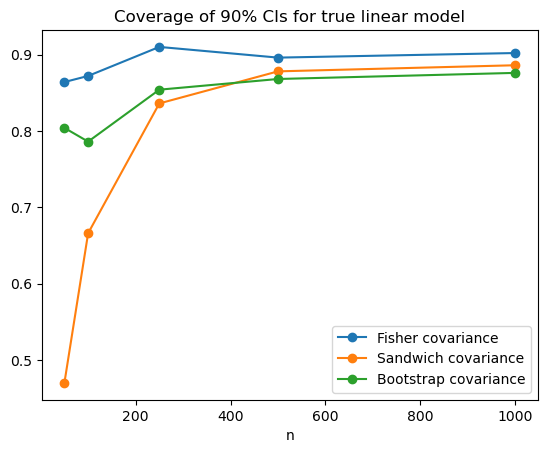

In [43]:
coverage = {"fisher": np.zeros(len(n_vals)), "sandwich": np.zeros(len(n_vals)), "bootstrap": np.zeros(len(n_vals))}
for i, n in enumerate(n_vals):
    for _ in range(num_trials):
        # generate data
        b_star = np.random.random(d)
        X = np.random.multivariate_normal(np.zeros(d), np.eye(d), n)
        sigma_sq = np.random.random()
        y = X @ b_star + np.random.normal(0, np.sqrt(sigma_sq), n)
        b_hat = np.linalg.inv(X.T @ X) @ X.T @ y
        y_hat = X @ b_hat

        # compute Fisher covariance
        XTX_inv = np.linalg.inv(X.T @ X)
        sigma_sq_hat = np.sum((y - y_hat)**2) / (n - d)
        fisher_cov = sigma_sq_hat * XTX_inv
        
        # compute sandwich covariance
        sandwich_cov = XTX_inv @ (X.T @ np.diag((y-y_hat)**2) @ X) @ XTX_inv

        # # compute boostrap covariance
        idx = np.random.choice(np.arange(n), size=(B,n)) # (B, n)
        X_bs = X[idx] # (B, n, d)
        y_bs = y[idx] # (B, n)
        X_bs_T = X_bs.transpose(0, 2, 1) # (B, d, n)
        b_hat_bs = (np.linalg.inv(X_bs_T @ X_bs) @ X_bs_T @ y_bs[:,:,None]).squeeze() # (B, d)
        bootstrap_cov = (b_hat_bs - b_hat).T @ (b_hat_bs - b_hat) / B

        cov_estimates = {"fisher": fisher_cov, "sandwich": sandwich_cov, "bootstrap": bootstrap_cov}
        for name, cov in cov_estimates.items():
            if (b_star - b_hat).T @ np.linalg.inv(cov) @ (b_star - b_hat) <= chi2.ppf(1-alpha, df=d):
                coverage[name][i] += 1/num_trials
                
# plot coverage
for name in coverage.keys():
    plt.plot(n_vals, coverage[name], marker='o', label=f'{name.capitalize()} covariance')
plt.xlabel('n')
plt.title('Coverage of 90% CIs for true linear model')
plt.legend()
plt.show()

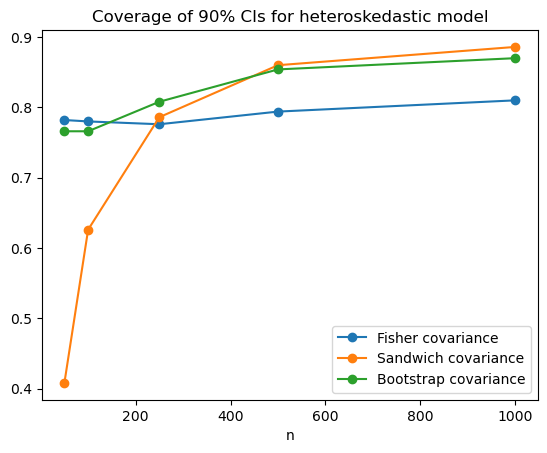

In [52]:
coverage = {"fisher": np.zeros(len(n_vals)), "sandwich": np.zeros(len(n_vals)), "bootstrap": np.zeros(len(n_vals))}
for i, n in enumerate(n_vals):
    for _ in range(num_trials):
        # generate data
        b_star = np.random.random(d)
        X = np.random.multivariate_normal(np.zeros(d), np.eye(d), n)
        sigma_sq = np.random.random()
        y = X @ b_star + np.random.normal(0, np.sqrt(sigma_sq) * np.linalg.norm(X, axis=1), n)
        b_hat = np.linalg.inv(X.T @ X) @ X.T @ y
        y_hat = X @ b_hat

        # compute Fisher covariance
        XTX_inv = np.linalg.inv(X.T @ X)
        sigma_sq_hat = np.sum((y - y_hat)**2) / (n - d)
        fisher_cov = sigma_sq_hat * XTX_inv
        
        # compute sandwich covariance
        sandwich_cov = XTX_inv @ (X.T @ np.diag((y-y_hat)**2) @ X) @ XTX_inv

        # compute boostrap covariance
        idx = np.random.choice(np.arange(n), size=(B,n)) # (B, n)
        X_bs = X[idx] # (B, n, d)
        y_bs = y[idx] # (B, n)
        X_bs_T = X_bs.transpose(0, 2, 1) # (B, d, n)
        b_hat_bs = (np.linalg.inv(X_bs_T @ X_bs) @ X_bs_T @ y_bs[:,:,None]).squeeze() # (B, d)
        bootstrap_cov = (b_hat_bs - b_hat).T @ (b_hat_bs - b_hat) / B

        cov_estimates = {"fisher": fisher_cov, "sandwich": sandwich_cov, "bootstrap": bootstrap_cov}
        for name, cov in cov_estimates.items():
            if (b_star - b_hat).T @ np.linalg.inv(cov) @ (b_star - b_hat) <= chi2.ppf(1-alpha, df=d):
                coverage[name][i] += 1/num_trials

# plot coverage
for name in coverage.keys():
    plt.plot(n_vals, coverage[name], marker='o', label=f'{name.capitalize()} covariance')
plt.xlabel('n')
plt.title('Coverage of 90% CIs for heteroskedastic model')
plt.legend()
plt.show()

In the first experiment, since the homoskedasticity and independence assumptions are met, the Fisher consistently attains close to 90% coverage; on the other hand, the sandwich covariance estimator requires more samples to achieve similar performance since it makes far fewer assumptions.

In the second experiment with heteroskedastic error terms however, the Fisher covariance performs much worse than the other methods.